In [10]:
%matplotlib inline
import matplotlib, sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import scipy
from scipy.stats import normaltest
import pandas as pd
import math

### Version Numbers

In [11]:
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd), 
             ('Scipy', scipy), ('Seaborn', sns), ('Sklearn', sklearn))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda custom (x86_64)| (default, Jul 20 2017, 13:14:59) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.13.1
Pandas Version: 0.20.3
Scipy Version: 0.19.1
Seaborn Version: 0.8.0
Sklearn Version: 0.19.0


In [12]:
df = pd.read_pickle('df4.p')

In [13]:
df.head()

,Price_Index,1 liter (1/4 gallon) of gas,Combo meal in fast food restaurant (Big Mac Meal or similar),Internet 8 Mbps (1 month),Monthly rent for 85 m2 (900 Sqft) furnished accommodation in EXPENSIVE area,Monthly ticket public transport,"Volkswagen Golf 1.4 TSI 150 CV (or equivalent), with no extras, new",log_rent,log_pi,Region,Asia,Central America,Eastern Europe,Middle East,North America,Oceania,South America,Western Europe
"Zurich, Switzerland",258,1.56,15.0,50.0,3192,104,28178,8.068403,5.552960,Western Europe,0,0,0,0,0,0,0,1
"Geneva, Switzerland",257,1.66,14.0,52.0,3761,73,26713,8.232440,5.549076,Western Europe,0,0,0,0,0,0,0,1
"Grand Cayman, Cayman Islands",255,1.17,11.0,99.0,3191,106,32956,8.068090,5.541264,Central America,0,1,0,0,0,0,0,0
"New York City, United States",245,0.72,8.0,49.0,3675,119,22312,8.209308,5.501258,North America,0,0,0,0,1,0,0,0
"Reykjavik, Iceland",240,1.86,16.0,61.0,2503,107,32704,7.825245,5.480639,Western Europe,0,0,0,0,0,0,0,1


### Class for statistical calculations

In [14]:
class Stats:
    
    def __init__(self, X, y, model):
        self.data = X
        self.target = y
        self.model = model
        self._dft = X.shape[0] - 1  ## degrees of freedom population dep. variable variance 
        self._dfe = X.shape[0] - X.shape[1] - 1  ## degrees of freedom population error variance
    
    def sse(self):
        '''returns sum of squared errors (model vs actual)'''
        squared_errors = (self.target - self.model.predict(self.data)) ** 2
        return np.sum(squared_errors)
        
    def sst(self):
        '''returns total sum of squared errors (actual vs avg(actual))'''
        avg_y = np.mean(self.target)
        squared_errors = (self.target - avg_y) ** 2
        return np.sum(squared_errors)
    
    def r_squared(self):
        '''returns calculated value of adjusted r^2'''
        return 1 - self.sse()/self.sst()
    
    def adj_r_squared(self):
        '''returns calculated value of adjusted r^2'''
        return 1 - (self.sse()/self._dfe) / (self.sst()/self._dft)

### Pretty Print Stats

In [15]:
def pretty_print_stats(stats_obj):
    '''returns report of statistics for a given model object'''
    items = ( ('sse:', stats_obj.sse()), ('sst:', stats_obj.sst()), 
             ('r^2:', stats_obj.r_squared()), ('adj_r^2:', stats_obj.adj_r_squared()) )
    for item in items:
        print('{0:8} {1:.4f}'.format(item[0], item[1]))

## Linear Regression Assumptions

1. Linear relationship between target and features
2. No outliers
3. No high-leverage points 
4. Homoscedasticity of error terms
5. Uncorrelated error terms 
6. Independent features

## [1] Linear relationship between target & features

In [16]:
df.corr()['Price_Index'].sort_values(ascending = False)

Price_Index                                                                    1.000000
log_pi                                                                         0.978488
Monthly rent for 85 m2 (900 Sqft) furnished accommodation in EXPENSIVE area    0.902509
log_rent                                                                       0.895580
Monthly ticket public transport                                                0.822602
Combo meal in fast food restaurant (Big Mac Meal or similar)                   0.761434
Internet 8 Mbps (1 month)                                                      0.568273
Western Europe                                                                 0.326640
North America                                                                  0.310238
Volkswagen Golf 1.4 TSI 150 CV (or equivalent), with no extras, new            0.262115
Oceania                                                                        0.204717
1 liter (1/4 gallon) of gas     

### Run a regression with one feature, monthly rent.

In [17]:
df1 = df.copy()
df1.sort_values('Monthly rent for 85 m2 (900 Sqft) furnished accommodation in EXPENSIVE area', ascending = False, inplace = True)

In [18]:
# sklearn needs a 2d array
X = df1.loc[:,'Monthly rent for 85 m2 (900 Sqft) furnished accommodation in EXPENSIVE area'].values.reshape(-1,1)
y = df1.loc[:,'Price_Index'].values.reshape(-1,1) 

In [19]:
print(X.shape, y.shape)

(323, 1) (323, 1)


In [20]:
linear = LinearRegression()
linear.fit(X, y);

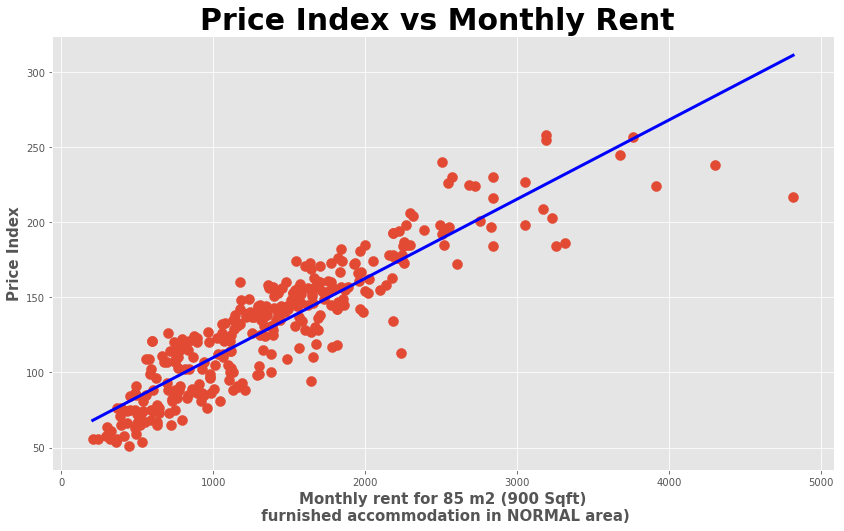

In [21]:
plt.style.use('ggplot')
fig = plt.figure(1, figsize = (14, 8))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Monthly rent for 85 m2 (900 Sqft)\n furnished accommodation in NORMAL area)', fontsize=15, weight='bold')
ax1.set_ylabel('Price Index', fontsize=15, weight='bold')
ax1.set_title('Price Index vs Monthly Rent ', fontsize=30, weight='bold')

ax1.plot(X, linear.predict(X), linewidth = 3, color ='b')
ax1.scatter(y ='Price_Index', x = 'Monthly rent for 85 m2 (900 Sqft) furnished accommodation in EXPENSIVE area', data = df1, s=100);

In [22]:
# R^2 for Monthly Rent on Price_Index
linear.score(X, y)

0.81452254280094838

In [23]:
stats = Stats(X, y, linear)

In [24]:
pretty_print_stats(stats)

sse:     115653.4509
sst:     623544.5139
r^2:     0.8145
adj_r^2: 0.8139


### Potential Problem: Non-linear Relationship
### Try log of monthly rent

In [25]:
Xlog = df1.loc[:,'log_rent'].values.reshape(-1,1)
ylog = df1.loc[:,'Price_Index'].values.reshape(-1,1) 

In [26]:
log = LinearRegression()
log.fit(Xlog, ylog);

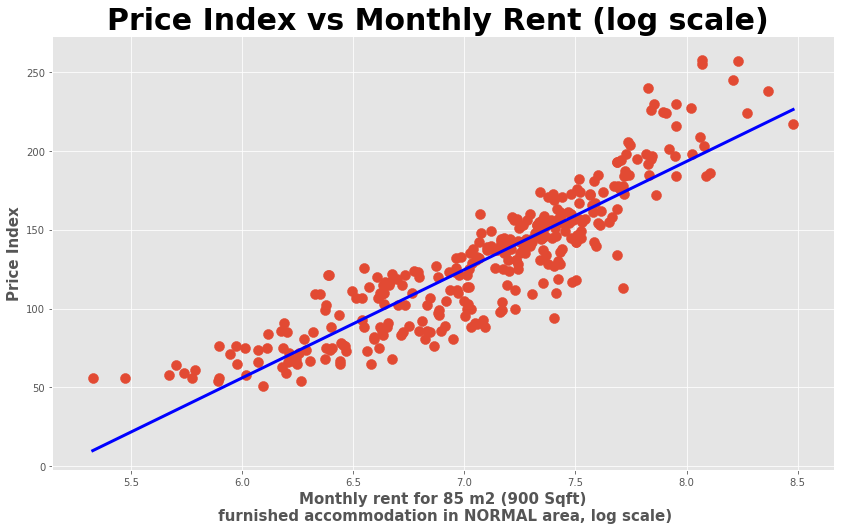

In [27]:
plt.style.use('ggplot')
fig = plt.figure(1, figsize = (14, 8))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Monthly rent for 85 m2 (900 Sqft)\n furnished accommodation in NORMAL area, log scale)', fontsize=15, weight='bold')
ax1.set_ylabel('Price Index', fontsize=15, weight='bold')
ax1.set_title('Price Index vs Monthly Rent (log scale) ', fontsize=30, weight='bold')
ax1.plot(Xlog, log.predict(Xlog), linewidth = 3, color ='b')
ax1.scatter(y ='Price_Index', x = 'log_rent', data = df1, s=100);

### There seem to be two groups, a high rent group and a low rent group.  
### Set the high/low threshhold at $3000/month

In [28]:
high_rent = df1.loc[df['Monthly rent for 85 m2 (900 Sqft) furnished accommodation in EXPENSIVE area'] > 3000]
low_rent = df1.loc[df['Monthly rent for 85 m2 (900 Sqft) furnished accommodation in EXPENSIVE area'] < 3000]

In [29]:
Xhigh = high_rent.loc[:,'Monthly rent for 85 m2 (900 Sqft) furnished accommodation in EXPENSIVE area'].values.reshape(-1,1)
yhigh = high_rent.loc[:,'Price_Index'].values.reshape(-1,1) 

In [30]:
Xlow = low_rent.loc[:,'Monthly rent for 85 m2 (900 Sqft) furnished accommodation in EXPENSIVE area'].values.reshape(-1,1)
ylow = low_rent.loc[:,'Price_Index'].values.reshape(-1,1) 

In [31]:
high_linear = LinearRegression()
high_linear.fit(Xhigh, yhigh);

In [32]:
low_linear = LinearRegression()
low_linear.fit(Xlow, ylow);

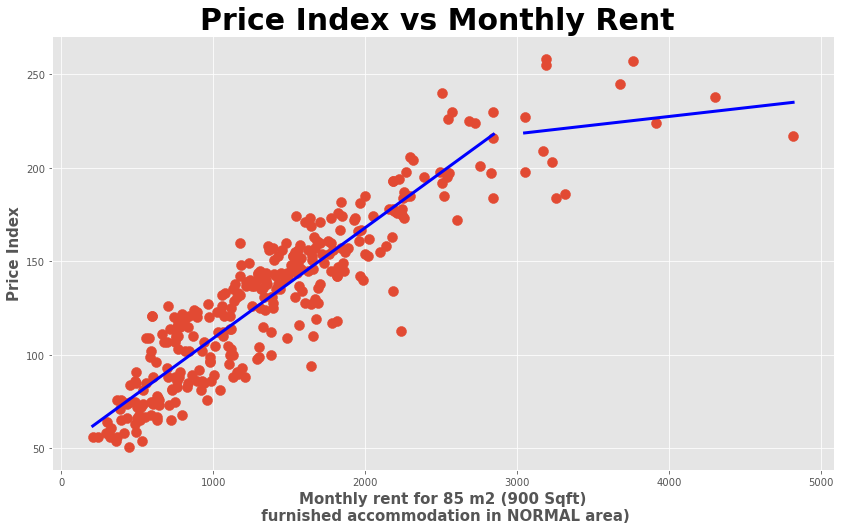

In [33]:
plt.style.use('ggplot')
fig = plt.figure(1, figsize = (14, 8))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Monthly rent for 85 m2 (900 Sqft)\n furnished accommodation in NORMAL area)', fontsize=15, weight='bold')
ax1.set_ylabel('Price Index', fontsize=15, weight='bold')
ax1.set_title('Price Index vs Monthly Rent ', fontsize=30, weight='bold')

ax1.plot(Xhigh, high_linear.predict(Xhigh), linewidth = 3, color ='b')
ax1.plot(Xlow, low_linear.predict(Xlow), linewidth = 3, color ='b')
ax1.scatter(y ='Price_Index', x = 'Monthly rent for 85 m2 (900 Sqft) furnished accommodation in EXPENSIVE area', data = df1, s=100);

In [34]:
# R^2 for high rent on Price_Index

In [35]:
high_linear.score(Xhigh, yhigh)

0.036225155094468442

In [36]:
stats_high = Stats(Xhigh, yhigh, high_linear)
pretty_print_stats(stats_high)

sse:     7977.8316
sst:     8277.6923
r^2:     0.0362
adj_r^2: -0.0514


In [37]:
# R^2 for low rent on Price_Index

In [38]:
low_linear.score(Xlow, ylow)

0.818499489873866

In [39]:
stats_low = Stats(Xlow, ylow, low_linear)
pretty_print_stats(stats_low)

sse:     90647.0902
sst:     499431.6000
r^2:     0.8185
adj_r^2: 0.8179


We can check to see if our model is capturing the underlying pattern effectively. Specifically, let's generate side-by-side **Residual Plots**. 

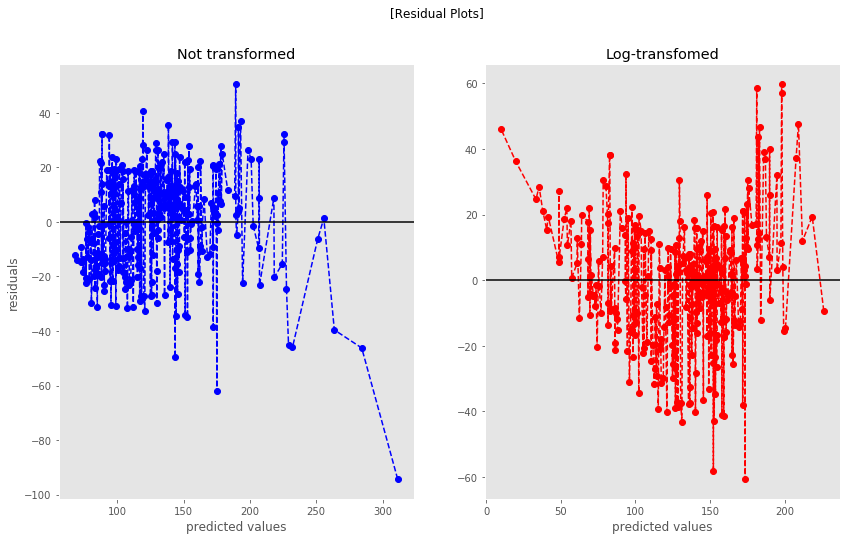

In [40]:
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False)
fig.suptitle('[Residual Plots]')
fig.set_size_inches(14,8)
axes[0].plot(linear.predict(X), y-linear.predict(X), 'bo--')
axes[0].axhline(y=0, color='k')
axes[0].grid()
axes[0].set_title('Not transformed')
axes[0].set_xlabel('predicted values')
axes[0].set_ylabel('residuals')
axes[1].plot(log.predict(Xlog), y-log.predict(Xlog), 'ro--')
axes[1].axhline(y=0, color='k')
axes[1].grid()
axes[1].set_title('Log-transfomed')
axes[1].set_xlabel('predicted values');

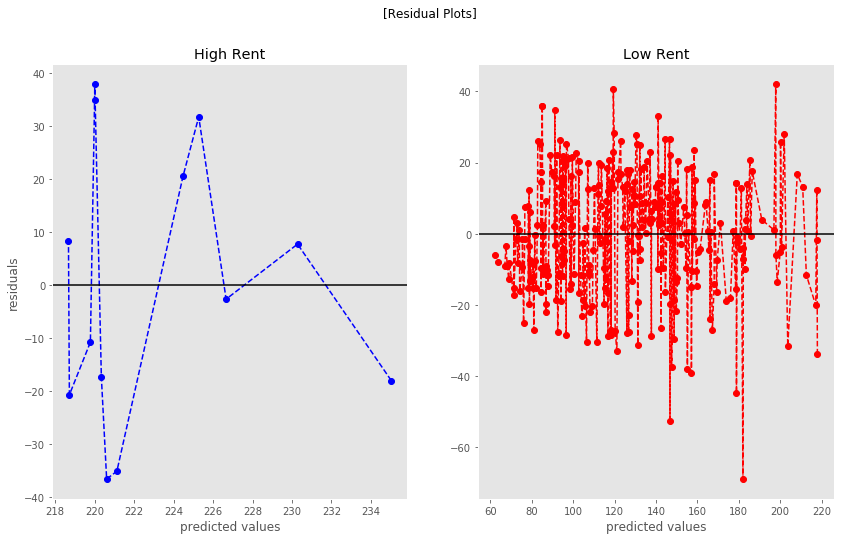

In [41]:
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False)
fig.suptitle('[Residual Plots]')
fig.set_size_inches(14,8)
axes[0].plot(high_linear.predict(Xhigh), yhigh-high_linear.predict(Xhigh), 'bo--')
axes[0].axhline(y=0, color='k')
axes[0].grid()
axes[0].set_title('High Rent')
axes[0].set_xlabel('predicted values')
axes[0].set_ylabel('residuals')
axes[1].plot(low_linear.predict(Xlow), ylow-low_linear.predict(Xlow), 'ro--')
axes[1].axhline(y=0, color='k')
axes[1].grid()
axes[1].set_title('Low Rent')
axes[1].set_xlabel('predicted values');

Using the data as-is with our linear model will result in a relatively poor model fit.

**Solutions:** consider transforming the features or apply a different algorithm.

Let's see what we can do with polynomial regression in this scenario:

In [36]:
df1.head()

,Price_Index,1 liter (1/4 gallon) of gas,Combo meal in fast food restaurant (Big Mac Meal or similar),Internet 8 Mbps (1 month),Monthly rent for 85 m2 (900 Sqft) furnished accommodation in EXPENSIVE area,Monthly ticket public transport,"Volkswagen Golf 1.4 TSI 150 CV (or equivalent), with no extras, new",log_rent,log_pi,Region,Asia,Central America,Eastern Europe,Middle East,North America,Oceania,South America,Western Europe
"Hong Kong, China",217,1.91,4.66,26.0,4815,67,29370,8.479491,5.379897,Asia,1,0,0,0,0,0,0,0
"San Francisco, California, United States",238,0.80,8.00,48.0,4302,79,22734,8.366835,5.472271,North America,0,0,0,0,1,0,0,0
"Mountain View, California, United States",224,0.77,8.00,56.0,3911,107,23405,8.271548,5.411646,North America,0,0,0,0,1,0,0,0
"Geneva, Switzerland",257,1.66,14.00,52.0,3761,73,26713,8.232440,5.549076,Western Europe,0,0,0,0,0,0,0,1
"New York City, United States",245,0.72,8.00,49.0,3675,119,22312,8.209308,5.501258,North America,0,0,0,0,1,0,0,0


In [37]:
poly = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))])

In [38]:
Xpoly = df1.loc[:,'Monthly rent for 85 m2 (900 Sqft) furnished accommodation in EXPENSIVE area'].values.reshape(-1,1)
ypoly = df1.loc[:,'Price_Index'].values.reshape(-1,1)

In [39]:
poly.fit(Xpoly, ypoly);

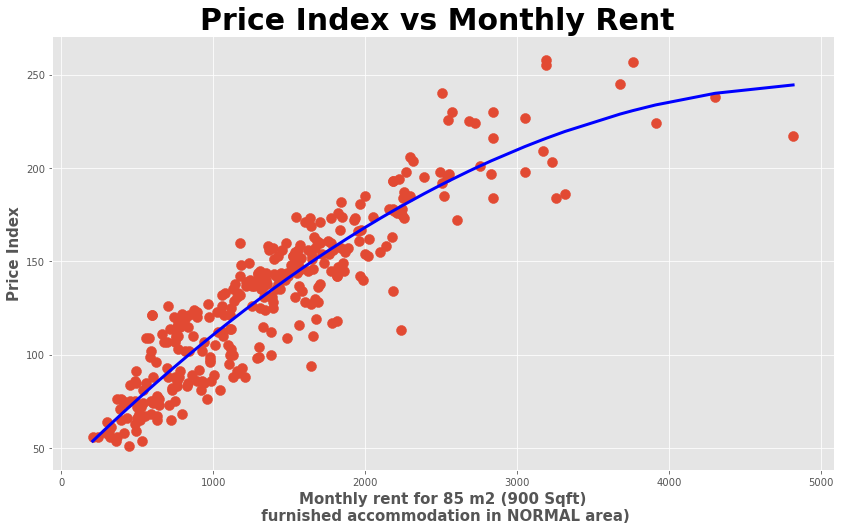

In [40]:
plt.style.use('ggplot')
fig = plt.figure(1, figsize = (14, 8))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Monthly rent for 85 m2 (900 Sqft)\n furnished accommodation in NORMAL area)', fontsize=15, weight='bold')
ax1.set_ylabel('Price Index', fontsize=15, weight='bold')
ax1.set_title('Price Index vs Monthly Rent ', fontsize=30, weight='bold')

ax1.plot(Xpoly, poly.predict(Xpoly), linewidth = 3, color ='b')
ax1.scatter(y ='Price_Index', x = 'Monthly rent for 85 m2 (900 Sqft) furnished accommodation in EXPENSIVE area', data = df, s=100);

In [41]:
# R^2 
poly.score(Xpoly, ypoly)

0.8421858785469204

In [42]:
polystats = Stats(Xpoly, ypoly, poly)
pretty_print_stats(polystats)

sse:     98404.1297
sst:     623544.5139
r^2:     0.8422
adj_r^2: 0.8417


In [43]:
poly1 = Pipeline([('poly', PolynomialFeatures(degree=3)),
                  ('linear', LinearRegression(fit_intercept=False))])

In [44]:
Xpoly1 = df1.loc[:,'Monthly rent for 85 m2 (900 Sqft) furnished accommodation in EXPENSIVE area'].values.reshape(-1,1)
ypoly1 = df1.loc[:,'Price_Index'].values.reshape(-1,1)

In [45]:
poly1.fit(Xpoly1, ypoly1);

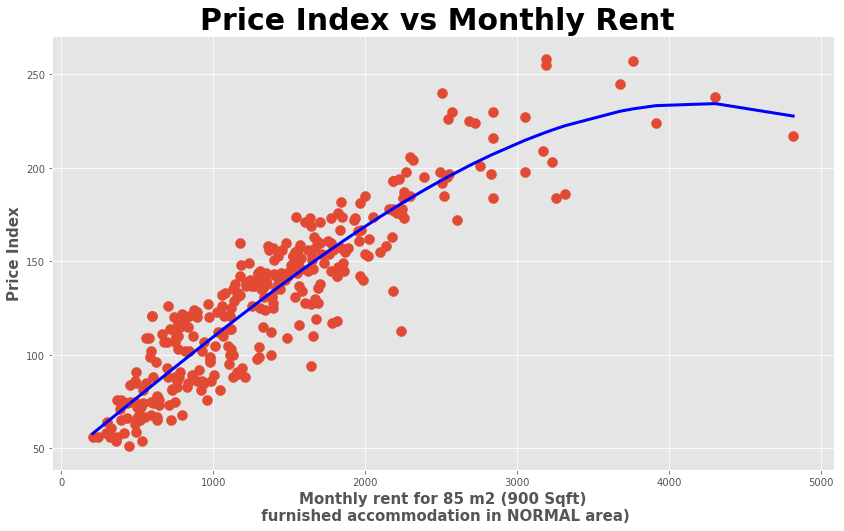

In [46]:
plt.style.use('ggplot')
fig = plt.figure(1, figsize = (14, 8))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Monthly rent for 85 m2 (900 Sqft)\n furnished accommodation in NORMAL area)', fontsize=15, weight='bold')
ax1.set_ylabel('Price Index', fontsize=15, weight='bold')
ax1.set_title('Price Index vs Monthly Rent ', fontsize=30, weight='bold')

ax1.plot(Xpoly1, poly1.predict(Xpoly1), linewidth = 3, color ='b')
ax1.scatter(y ='Price_Index', x = 'Monthly rent for 85 m2 (900 Sqft) furnished accommodation in EXPENSIVE area', data = df, s=100);

In [47]:
# R^2 
poly1.score(Xpoly1, ypoly1)

0.84359480819474875

Only a slight increase in Adj R^2, it might not be worth the increase in complexity.

In [48]:
poly1stats = Stats(Xpoly1, ypoly1, poly1)
pretty_print_stats(poly1stats)

sse:     97525.5993
sst:     623544.5139
r^2:     0.8436
adj_r^2: 0.8431


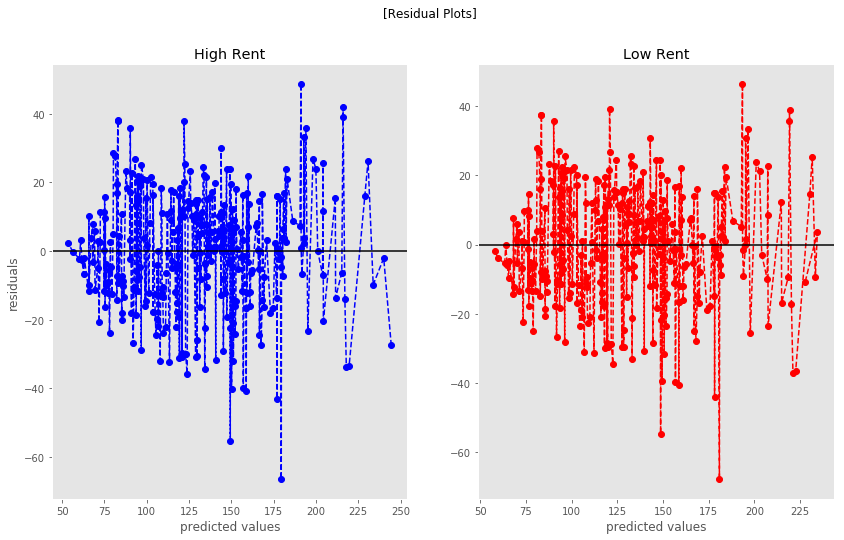

In [49]:
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False)
fig.suptitle('[Residual Plots]')
fig.set_size_inches(14,8)
axes[0].plot(poly.predict(Xpoly), ypoly-poly.predict(Xpoly), 'bo--')
axes[0].axhline(y=0, color='k')
axes[0].grid()
axes[0].set_title('High Rent')
axes[0].set_xlabel('predicted values')
axes[0].set_ylabel('residuals')
axes[1].plot(poly1.predict(Xpoly1), ypoly1-poly1.predict(Xpoly1), 'ro--')
axes[1].axhline(y=0, color='k')
axes[1].grid()
axes[1].set_title('Low Rent')
axes[1].set_xlabel('predicted values');

### Try polytransform with log_rent

In [50]:
polylog = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))])

In [51]:
Xpolylog = df1.loc[:,'log_rent'].values.reshape(-1,1)
ypolylog = df1.loc[:,'Price_Index'].values.reshape(-1,1) 

In [52]:
polylog.fit(Xpolylog, ypolylog);

In [67]:
predictions = polylog.predict(Xpolylog)
residuals = ypolylog - predictions

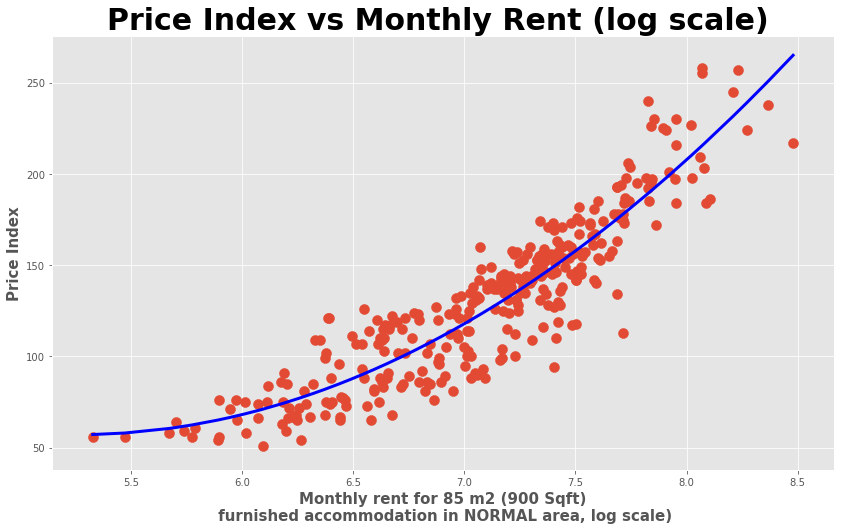

In [53]:
plt.style.use('ggplot')
fig = plt.figure(1, figsize = (14, 8))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Monthly rent for 85 m2 (900 Sqft)\n furnished accommodation in NORMAL area, log scale)', fontsize=15, weight='bold')
ax1.set_ylabel('Price Index', fontsize=15, weight='bold')
ax1.set_title('Price Index vs Monthly Rent (log scale) ', fontsize=30, weight='bold')
ax1.plot(Xpolylog, polylog.predict(Xpolylog), linewidth = 3, color ='b')
ax1.scatter(y ='Price_Index', x = 'log_rent', data = df1, s=100);

In [54]:
polylogstats = Stats(Xpolylog, ypolylog, polylog)
pretty_print_stats(polylogstats)

sse:     100533.8415
sst:     623544.5139
r^2:     0.8388
adj_r^2: 0.8383


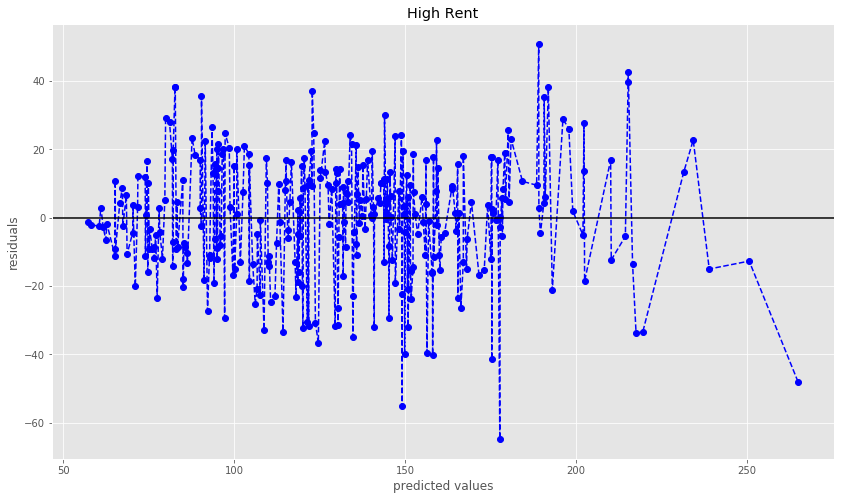

In [65]:
fig, axes = plt.subplots(1, 1, sharex=False, sharey=False)
#fig.suptitle('[Residual Plots]')
fig.set_size_inches(14,8)
axes.plot(polylog.predict(Xpolylog), ypolylog-polylog.predict(Xpolylog), 'bo--')
axes.axhline(y=0, color='k')
axes.set_title('High Rent')
axes.set_xlabel('predicted values')
axes.set_ylabel('residuals');

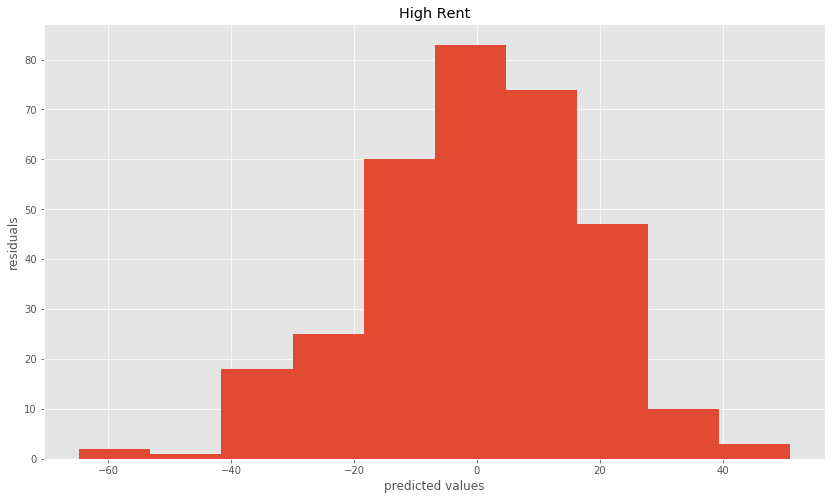

In [69]:
fig, axes = plt.subplots(1, 1, sharex=False, sharey=False)
fig.set_size_inches(14,8)
axes.hist(residuals)
axes.set_title('High Rent')
axes.set_xlabel('predicted values')
axes.set_ylabel('residuals');

### The second degree polynomial is giving the best combination of less model complexity and high predictive value. I will proceed forward with it. 

In [43]:
def make_linear_model_and_plot(X, y, verbose = True, plot = True, residual_plot = True, hist_plot = True):
    '''
    input: X, y as array of features and array of targets
    output: summary statistics, graphs of predicted vs actual, and graph of residuals vs y
    '''

    linear = LinearRegression()
    linear.fit(X, y);
    
    stats = Stats(X, y, linear)
    
    if verbose:
        pretty_print_stats(stats)
        
    predictions = linear.predict(X)
    residuals = y - predictions
    
    if plot:
        fig = plt.figure(1, figsize = (14, 8))
        ax1 = fig.add_subplot(111)
        ax1.set_xlabel('Predicted Price Index', fontsize=15, weight='bold')
        ax1.set_ylabel('Actual Price Index', fontsize=15, weight='bold')
        ax1.set_title('Actual Price Index vs Predicted Price Index', fontsize=30, weight='bold')
        ax1.plot([50,275], [50, 275], color = 'b', linewidth = 3, label = 'Perfect Predictions')

        ax1.scatter(x = linear.predict(X) , y = y, s=100)
        ax1.legend();
    
    if residual_plot:
        fig = plt.figure(2, figsize = (14, 8))
        ax1 = fig.add_subplot(111)
        ax1.set_xlabel('Predicted Price Index', fontsize=15, weight='bold')
        ax1.set_ylabel('Residuals', fontsize=15, weight='bold')
        ax1.set_title('Residuals vs Predicted Price Index', fontsize=30, weight='bold')
        ax1.scatter(x = predictions, y = residuals, s=100);
    
    if hist_plot:
        fig = plt.figure(3, figsize = (14, 8))
        ax1 = fig.add_subplot(111)
        ax1.set_xlabel('Residuals', fontsize=15, weight='bold')
        ax1.set_ylabel('Frequency', fontsize=15, weight='bold')
        ax1.set_title('Histogram of Residuals', fontsize=30, weight='bold')
        ax1.hist(residuals);
        
    return predictions, residuals

In [44]:
def make_poly_model_and_plot(X, y, degree = 2, verbose = True, plot = True, residual_plot = True, hist_plot = True):
    '''
    input: X, y as array of features and array of targets
    output: summary statistics, graphs of predicted vs actual, and graph of residuals vs y
    '''

    poly = Pipeline([('poly', PolynomialFeatures(degree=degree)),
              ('linear', LinearRegression(fit_intercept=False))])
    poly.fit(X,y)

    stats = Stats(X, y, poly)
    
    if verbose:
        pretty_print_stats(stats)
        
    predictions = poly.predict(X)
    residuals = y - predictions
    
    if plot:
        fig = plt.figure(1, figsize = (14, 8))
        ax1 = fig.add_subplot(111)
        ax1.set_xlabel('Predicted Price Index', fontsize=15, weight='bold')
        ax1.set_ylabel('Actual Price Index', fontsize=15, weight='bold')
        ax1.set_title('Actual Price Index vs Predicted Price Index', fontsize=30, weight='bold')
        ax1.plot([50,275], [50, 275], color = 'b', linewidth = 3, label = 'Perfect Predictions')

        ax1.scatter(x = poly.predict(X) , y = y, s=100)
        ax1.legend();
    
    if residual_plot:
        fig = plt.figure(2, figsize = (14, 8))
        ax1 = fig.add_subplot(111)
        ax1.set_xlabel('Predicted Price Index', fontsize=15, weight='bold')
        ax1.set_ylabel('Residuals', fontsize=15, weight='bold')
        ax1.set_title('Residuals vs Predicted Price Index', fontsize=30, weight='bold')
        ax1.scatter(x = predictions, y = residuals, s=100);
    
    if hist_plot:
        fig = plt.figure(3, figsize = (14, 8))
        ax1 = fig.add_subplot(111)
        ax1.set_xlabel('Residuals', fontsize=15, weight='bold')
        ax1.set_ylabel('Frequency', fontsize=15, weight='bold')
        ax1.set_title('Histogram of Residuals', fontsize=30, weight='bold')
        ax1.hist(residuals);
        
    return predictions, residuals

### Build a model with poly transformed model, and the region dummy variables.

In [45]:
Xpoly = df1.loc[:,['Monthly rent for 85 m2 (900 Sqft) furnished accommodation in EXPENSIVE area', \
                'Asia', 'Central America', 'Eastern Europe', 'Middle East', 'North America', 'Oceania', \
                'South America', 'Western Europe']].values
ypoly = df1.loc[:,'Price_Index'].values.reshape(-1,1)

In [50]:
pred, res = make_poly_model_and_plot(Xpoly, ypoly, degree = 2, verbose = True, plot = False, residual_plot = False, hist_plot = False)

sse:     64814.1653
sst:     623544.5139
r^2:     0.8961
adj_r^2: 0.8931


The region dummy variable improves adj R^2 and SSE. I will add it to the model.

### Poly transformed model with 2 features and the dummy region features.

In [ ]:
df1.corr()

In [118]:
Xpoly = df1.loc[:,['Monthly rent for 85 m2 (900 Sqft) furnished accommodation in EXPENSIVE area', \
                   'Monthly ticket public transport',\
                'Asia', 'Central America', 'Eastern Europe', 'Middle East', 'North America', 'Oceania', \
                'South America', 'Western Europe']].values
ypoly = df1.loc[:,'Price_Index'].values.reshape(-1,1)

In [51]:
pred, res = make_poly_model_and_plot(Xpoly, ypoly, degree = 2, verbose = True, plot = False, residual_plot = False, hist_plot = False)

sse:     64814.1653
sst:     623544.5139
r^2:     0.8961
adj_r^2: 0.8931


### 3 features and region dummy variables

In [63]:
Xpoly = df1.loc[:,['Monthly rent for 85 m2 (900 Sqft) furnished accommodation in EXPENSIVE area', \
                   'Monthly ticket public transport',\
                   'Combo meal in fast food restaurant (Big Mac Meal or similar)',\
                'Asia', 'Central America', 'Eastern Europe', 'Middle East', 'North America', 'Oceania', \
                'South America', 'Western Europe']].values
ypoly = df1.loc[:,'Price_Index'].values.reshape(-1,1)

In [64]:
pred, res = make_poly_model_and_plot(Xpoly, ypoly, degree = 2, verbose = True, plot = False, residual_plot = False, hist_plot = False)

sse:     16484.6778
sst:     623544.5139
r^2:     0.9736
adj_r^2: 0.9726


### 4 features and region dummy variables

In [65]:
Xpoly = df1.loc[:,['Monthly rent for 85 m2 (900 Sqft) furnished accommodation in EXPENSIVE area',\
               'Monthly ticket public transport', \
                'Combo meal in fast food restaurant (Big Mac Meal or similar)',\
                'Internet 8 Mbps (1 month)',\
                'Asia', 'Central America', 'Eastern Europe', 'Middle East', 'North America', 'Oceania', \
                'South America', 'Western Europe'
                ]].values
ypoly = df1.loc[:,'Price_Index'].values.reshape(-1,1)

In [66]:
pred, res = make_poly_model_and_plot(Xpoly, ypoly, degree = 2, verbose = True, plot = False, residual_plot = False, hist_plot = False)

sse:     14757.6985
sst:     623544.5139
r^2:     0.9763
adj_r^2: 0.9754


Just a tiny improvement over the 3 features and region dummy variables model.

### 5 features and region dummy variables

In [67]:
Xpoly = df1.loc[:,['Monthly rent for 85 m2 (900 Sqft) furnished accommodation in EXPENSIVE area',\
               'Monthly ticket public transport', \
                'Combo meal in fast food restaurant (Big Mac Meal or similar)',\
                'Internet 8 Mbps (1 month)',\
                'Volkswagen Golf 1.4 TSI 150 CV (or equivalent), with no extras, new',\
                'Asia', 'Central America', 'Eastern Europe', 'Middle East', 'North America', 'Oceania', \
                'South America', 'Western Europe'
                ]].values
ypoly = df1.loc[:,'Price_Index'].values.reshape(-1,1)

In [68]:
pred, res = make_poly_model_and_plot(Xpoly, ypoly, degree = 2, verbose = True, plot = False, residual_plot = False, hist_plot = False)

sse:     11521.0190
sst:     623544.5139
r^2:     0.9815
adj_r^2: 0.9807


Another slight improvement in Adj R^2.

### One last model with all the features and the region dummy variables.

In [69]:
Xpoly = df1.loc[:,['Monthly rent for 85 m2 (900 Sqft) furnished accommodation in EXPENSIVE area',\
               'Monthly ticket public transport', \
                'Combo meal in fast food restaurant (Big Mac Meal or similar)',\
                'Internet 8 Mbps (1 month)',\
                'Volkswagen Golf 1.4 TSI 150 CV (or equivalent), with no extras, new',\
                '1 liter (1/4 gallon) of gas',
                'Asia', 'Central America', 'Eastern Europe', 'Middle East', 'North America', 'Oceania', \
                'South America', 'Western Europe'
                ]].values
ypoly = df1.loc[:,'Price_Index'].values.reshape(-1,1)

In [70]:
pred, res = make_poly_model_and_plot(Xpoly, ypoly, degree = 2, verbose = True, plot = False, residual_plot = False, hist_plot = False)

sse:     10249.9504
sst:     623544.5139
r^2:     0.9836
adj_r^2: 0.9828


Another slight improvement in Adj R^2. I will proceed forward with the model with the 3 features and the dummy region variables. It has good predictive power, Adj R^2 = 0.9726. Each additional feature isn't adding more to the Adj R^2.  

Let's make the full plots to look at the residuals.

sse:     16484.6778
sst:     623544.5139
r^2:     0.9736
adj_r^2: 0.9726


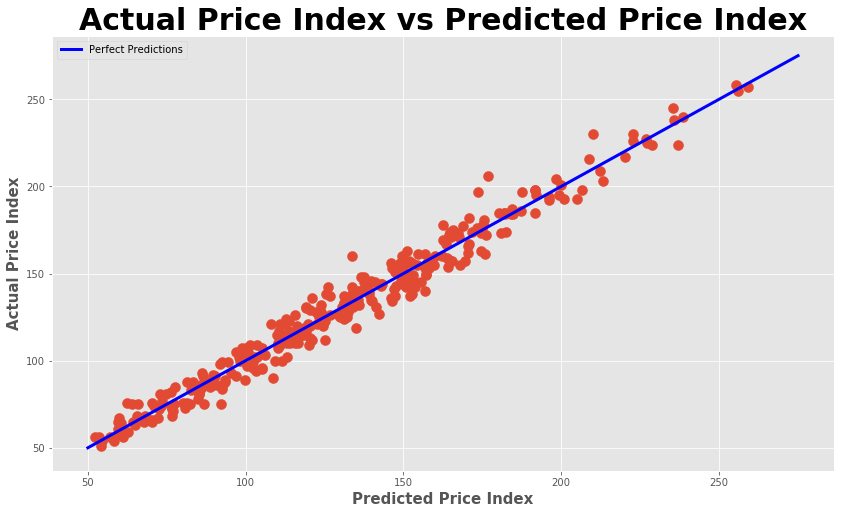

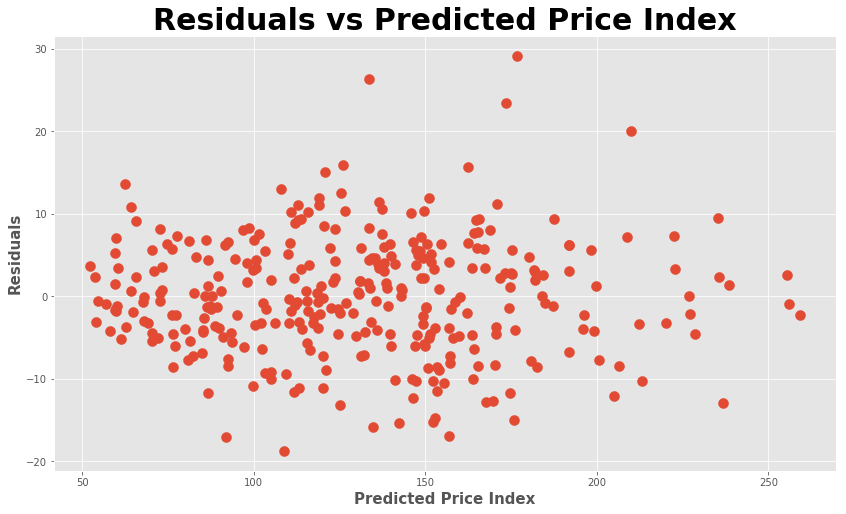

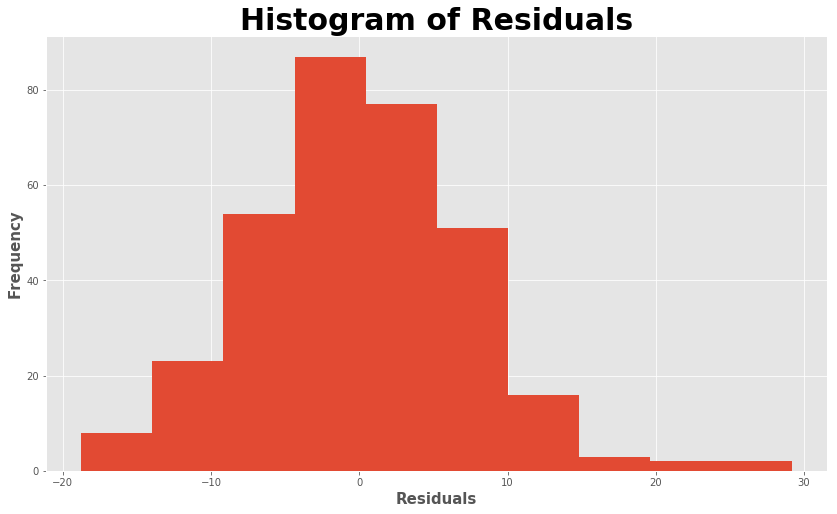

In [137]:
Xpoly = df1.loc[:,['Monthly rent for 85 m2 (900 Sqft) furnished accommodation in EXPENSIVE area', \
                   'Monthly ticket public transport',\
                   'Combo meal in fast food restaurant (Big Mac Meal or similar)',\
                'Asia', 'Central America', 'Eastern Europe', 'Middle East', 'North America', 'Oceania', \
                'South America', 'Western Europe']].values
ypoly = df1.loc[:,'Price_Index'].values.reshape(-1,1)
pred, res = make_poly_model_and_plot(Xpoly, ypoly, degree = 2, verbose = True, plot = True, residual_plot = True, hist_plot = True)

Residuals might have a right skew.

### Try non-poly transformed model

In [140]:
X = df1.loc[:,['Monthly rent for 85 m2 (900 Sqft) furnished accommodation in EXPENSIVE area',\
               'Monthly ticket public transport', \
                'Combo meal in fast food restaurant (Big Mac Meal or similar)',\
                'Internet 8 Mbps (1 month)',\
                'Volkswagen Golf 1.4 TSI 150 CV (or equivalent), with no extras, new',\
                'Asia', 'Central America', 'Eastern Europe', 'Middle East', 'North America', 'Oceania', \
                'South America', 'Western Europe'
                ]].values
y = df1.loc[:,'Price_Index'].values.reshape(-1,1)

In [59]:
pred, resid = make_linear_model_and_plot(X, y, verbose = True, plot = False, residual_plot = False, hist_plot = False)

sse:     115653.4509
sst:     623544.5139
r^2:     0.8145
adj_r^2: 0.8139


In [60]:
X = df1.loc[:,['Monthly rent for 85 m2 (900 Sqft) furnished accommodation in EXPENSIVE area',\
               'Monthly ticket public transport', \
                'Combo meal in fast food restaurant (Big Mac Meal or similar)'
                ]].values
y = df1.loc[:,'Price_Index'].values.reshape(-1,1)

In [61]:
pred, resid = make_linear_model_and_plot(X, y, verbose = True, plot = False, residual_plot = False, hist_plot = False)

sse:     28531.8974
sst:     623544.5139
r^2:     0.9542
adj_r^2: 0.9538


In [151]:
X = df1.loc[:,['Monthly rent for 85 m2 (900 Sqft) furnished accommodation in EXPENSIVE area',\
               'Monthly ticket public transport', \
                'Combo meal in fast food restaurant (Big Mac Meal or similar)',\
                'Asia', 'Central America', 'Eastern Europe', 'Middle East', 'North America', 'Oceania', \
                'South America', 'Western Europe'
                ]].values
y = df1.loc[:,'Price_Index'].values.reshape(-1,1)

In [62]:
pred, resid = make_linear_model_and_plot(X, y, verbose = True, plot = False, residual_plot = False, hist_plot = False)

sse:     28531.8974
sst:     623544.5139
r^2:     0.9542
adj_r^2: 0.9538


The residuals might have a right skew. 